In [1]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import unsupervised_helper as ushelp
%aimport unsupervised_helper

import mnist_helper as mnhelp
%aimport mnist_helper

import os 

import seaborn as sns; sns.set()


# Unsupervised Learning

- No targets
- Why use it ?
    - Understand your features
    - Better use of features in supervised models

- Dimensionality reduction
    - combine redundant features
- Clustering
    - group samples with similar features
        - similarity obscured in high dimensions
        - dimensionality reduction first, not necessary, but often helps

# Plan
- Principal Components
    - Highly popular model for dimensionality reduction
- Clustering
    - K-means to cluster samples
    - Hierarchical clustering
- Recommender systems
    - Netflix prize
    - Pseudo SVD

# What is PCA

- a way to reduce dimensionality of features
    - Do we really need all 784 pixels in MNIST ?
    - Hedging in Fixed Income
- a way to cluster samples based on similarity of *features*
- contrast this to Decision Tree
    - also clusters samples with similar features
    - but guided by the clusters having same targets




# PCA TL;DR

<div class="alert alert-block alert-warning">
    <b>TL;DR</b> 
    <ul>
        <li>PCA is a technique for creating "synthetic features" from the original set of features</li>
        <li>The synthetic features may better reveal relationships among original features</li>
        <li>May be able to use reduced set of synthetic features (dimensionality reduction)</li>
        <li>Synthetic features as a means of clustering samples</li>
        <li>All features need (and will be assumed to be) centered: zero mean</li>
        <li>PCA is very scale sensitive; often normalize each feature to put on same scale</li>
        </div>

## Notation

- feature matrix $X$
    - number of rows (samples) $n$
    - number of columns (features) $m$

## Example of correlated features
- [VanderPlas notebook](external/PythonDataScienceHandbook/notebooks/05.09-Principal-Component-Analysis.ipynb)

- Sample: workers within a single profession, with features including Age, Wage
    - Age and wage appear to be correlated
    
"Correlation doesn't imply causation" but sometimes
- correlated variables are different manifestations of a common concept ("factor")
- Age and Wage both related to Years of Experience
    - Years of Experience is common factor that explains why Age and Wage move together

Let's create two correlated features and plot them.

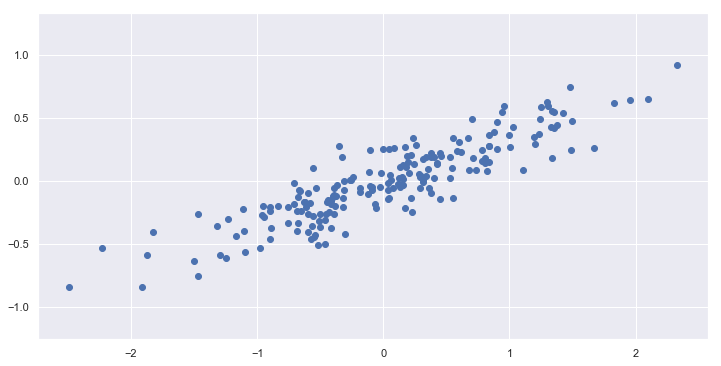

In [29]:
vp = ushelp.VanderPlas()
X = vp.create_data()

fig, ax = plt.subplots(1,1, figsize=(12,6))
_ =ax.scatter(X[:, 0], X[:, 1])
_ =ax.axis('equal');


### 2D example: showing how a correlated factor may be expressed

Understand correlation as an expression of a shared (common) factor
- wages correlated with age (within a profession)
    - common factor: years of experience
- can decompose each feature into
    - the part correlated with common factor $x_c$
    - the part independent (correlated with some other orthogonal factor)

$x_2 = \rho * (\sigma_2/\sigma_c) * x_c + \sqrt{1 - \rho^2} * \sigma_2 * z$
- where $\rho$ is correlation of $x_2, x_c$
- where $\sigma_c, \sigma_2$ are the standard deviations of $x_c, x_2$
- where $E(x_c, z) = 0$: $x_c$ is uncorrelated to $z$ (mean 0, unit variance)
- this is the regression of $x_2$ dependent on independent $x_c$
    - $\beta = \rho * \sigma_2/\sigma_c$, w

$$
\begin{array}{lll}
E(x_2^2) & = & \rho^2 (\sigma_2^2/\sigma_c^2)*E(x_c^2) + (1 - \rho^2) \sigma_2^2 * E(z^2) \\
\sigma_2^2 & = & \sigma_2^2 ( \rho^2 + (1 -\rho^2)) \\
\sigma_2^2 & = & \sigma_2^2 \\
\end{array}
$$

PCA will create synthetic features $\tilde{X}_1, \ldots, \tilde{X}_m$ that capture the commonality of the original.

Takes matrix $X$ with original features $X_1, \ldots, X_m$ .

Creates matrix $\tilde{X}$ with synthetic features $\tilde{X}_1, \ldots, \tilde{X}_m$

Each feature $X_i$ can be expressed as a linear combo of synthetic features $\tilde{X_j}$

$X_i = \Sigma_{j}^m { \beta_{i,j} * \tilde{X_j} }$



We will see that the synthetic features $\tilde{X}_j$ are constructed as combinations of original features

$\tilde{X}_i = \Sigma_{j}^m { \tilde{\beta}_{i,j} * X_j }$

### PCA as a rotation

Transform samples expressed over original features into samples expressed over synthetic features:

$\tilde{X} = T = X W$

- Transformed $\tilde{X}$ is a rotation of $X$ defined by $W$
    - columns of $T$ are synthetic features $\tilde{X}_j$ for $j = 1, \ldots, m$
    

The transformation $W$ for PCA has the properties

- $\tilde{X_i}, \tilde{X_j}$ uncorrelated for $i \ne j$
    - this means covariance matrix of features is diagonal (off-diagonal all zero)
- The standard deviations of the syntheti features is ordered:
    - $\sigma_{\tilde{X_i}} > \sigma_{\tilde{X_j}}, i < j$
    

Not surprisingly, in light of our re-writing $x_2$ in the form of a regression agains $x_c$:
- find a rotation
- the rotated horizontal axis will be the line of best fit
    - maximizes spread along rotated horizontal (max variance of first PC)
    - minimizes distance along axis orthogonal to rotated horizontal (second PC) from observations to line
        - these are the residuals of the regression

A picture will help

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
[0.7625315 0.0184779]


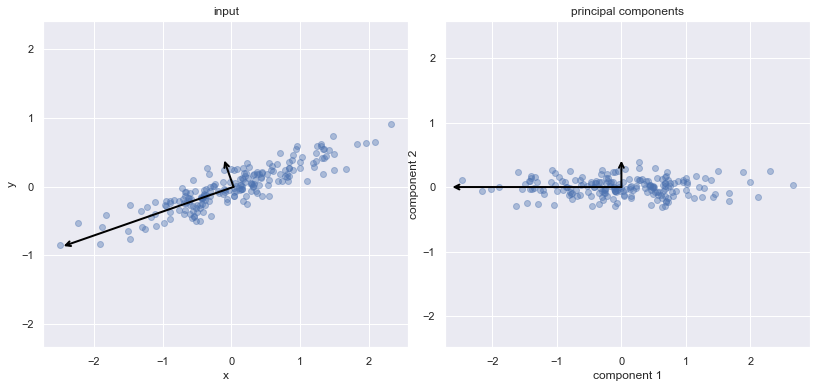

In [4]:
vp.show_2D(X)

# PCA via Matrix factorization

We will now show how to obtain the Principal Components via a technique called Matrix Factorization.

There are (at least) two ways to factor matrix $X$ into $X = U \Sigma V^T$

## SVD

Factor matrix $X$ into product of 3 matrices:
$$
X = U \Sigma V^T
$$
- U: $n \times m$, columns are orthogonal unit vectors
    - $U U^T = I$
- $\Sigma: m \times m$ diagonal matrix with diagonal elements $\sigma_1, \ldots, \sigma_m$

- $V: m \times m$, columns are orthogonal unit vectors
    - $V V^T = I$
    
Moreover, the diagonal elements of $\Sigma$ are in descending order of magnitude
$
\sigma_i > \sigma_j
$ for $i < j$

So the rotation $W$ described above which maps $X$ from original feature space to synthetic feature space is

$W = V$

as can be seen:
$$
\begin{array}{lll}
T & = & X V \\
  & = & (U \Sigma V^T) V \\
  & = & U \Sigma & \text{since } V^T V = I
\end{array}
$$

The decomposition creates synthetic features (latent factors, concepts)

 - $U$ maps samples to synthetic features (concepts)
     - maps to standardized concept (unit standard deviation) since $U U^T = I$
         - $\Sigma$ scales this back to abolute units
     - so column $y$ of $U$ shows concept via how it splits samples
     - and conversely, row $r$ shows how sample belongs to each concept

 - $\Sigma$ is "strength" of concepts
     - so $U \cdot \Sigma$ is sample (in units of non-standardized concept)
 - $V^T$ is synthetic feature (concept) to original feature
     - so row $x$ of $V^T$ 
         - shows concept $x$ expressed as weighted sum of original features
         - element $j$ of row $x$ shows how much  feature $X_j$ changes for a unit *standard deviation* change in synthetic feature $x$

The following is the projection of $X$ onto the standardized PC's $V^T$( so unit of axes is "number of standard deviations"), as opposed to $\Sigma V^T$ as above

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
[0.7625315 0.0184779]


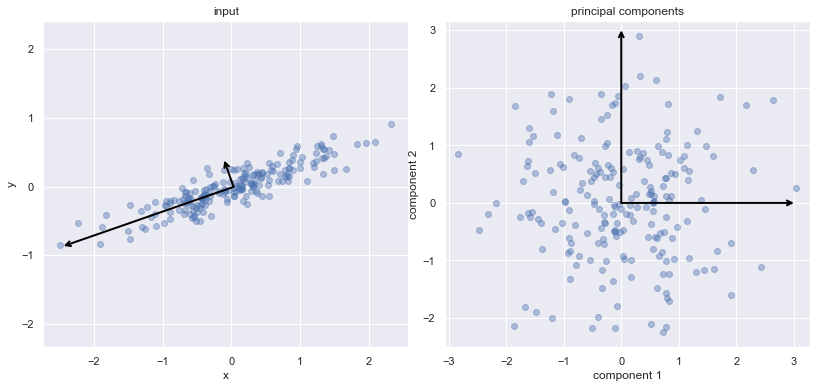

In [5]:
vp.show_2D(X, whiten=True)

## Eigen decomposition of covariance matrix of $X$

There is another matrix factorization method known as Eigen Decomposition.

Eigen decompostion, unlike SVD,  only works on symmetric matrices $M$:

$$
M = W \Lambda W^T
$$

where $W W^T = I$

We can relate the SVD of $X$ to the Eigen decomposition of $X X^T$, the covariance matrix of $X$, which is symmetric.

$
\begin{array}{lll}
X^T X & = &  V \Sigma U^TU \Sigma V^T  & \text{from } X  =  U \Sigma V^T \\
X^T X & = &  V \Sigma \Sigma^T V^T & \text{since } U^T U = I \\
\end{array}
$

Similarly, we can show

$
X^T X = U \Sigma \Sigma^T U^T
$

So the Eigen decomposition's $W = U = V$, and diagonal matrix is $\Lambda = \Sigma \Sigma^T$

So the $V$ needed for the transformation from $X$ (original feature space)
to $T = X V$ (synthetic feature space) 
- can be computed directly from SVD
- or by creating covariance matrix of $X$ and using eigen decomposition.

There are many fast implementations of SVD, and there is no need to compute $X X^T$ (as needed in Eigen decomposition) so SVD is now the more common approach.

## Other factorization methods

- CUR method
$$\textrm{CUR}(A) =  C \cdot U \cdot R$$ 
- $C$ chosen from Columns of $R$
- $R$ chosen from Rows of $A$

# Dimensionality reduction

So far, all we have done is 
- exactly reproduce $X$ by factoring it into 3 matrices
- re-express $X$ from original features to synthetic features

We will show a simple extension that will allow us to create "approximations" of $X$, using
fewer than $m$ synthetic features

Let's define what is means for $X'$ to be an approximation of $X$

$
{|| X' - X ||}_2 =  \sum\limits_{i,j}{ \left( {X'}_{i,j} - X_{i,j}\right)^2 }
$

The above is called the Froebenius Norm (and looks like MSE in form).

The "best" approximation $X'$ of $X$ is the one with the smallest norm.

## Best lower rank approximation of $X$

Let 

$X = U \Sigma V^T$

where 

$\Sigma$ is dimension $(m \times m)$ with diagonal element $\sigma_1, \ldots, \sigma_m$ such that

$
\sigma_i > \sigma_j
$ for $i < j$

$X_{\text{d-proj}}$ is the best rank $d$ approximation of $X$, i.e,

$X_{\text{d-proj}} = \textrm{argmin}_B { || X - B ||_2 }$

when

$X_{\text{d-proj}} = U S V^T$

where

$S$ is the dimension $(m \times m)$ diagonal matrix with
- first $d$ diagonal elements $\sigma_1, \ldots, \sigma_d$
- remaining $(m -d)$ diagonal elements set to $0$

The zero elements of $S$ render the last $(m-d)$ columns of $U$ and rows of $V^T$ irrelevant.

$X_{\text{d-proj}} = U_{\text{d-proj}} \Sigma_{\text{d-proj}} V^T_{\text{d-proj}}$

In words, this effectively reduces the dimensions of $U, \Sigma, V^T$:
- $U_{\text{d-proj}}$ to dimension $(n, d)$
- $\Sigma_{\text{d-proj}}$ to $(d,d)$
- $V^T_{\text{d-proj}}$ to $(d, m)$


In effect, we retain only the first $d$ synthetic features.

So we have reduced the dimension of $X$ from $m$ features to $d$ synthetic features.

### Why dropping low significance synthetic features is low error

Let's examine the reconstruction of $X$ from $U \Sigma V^T$

Let's  $T_{i,j}$ denote the element at row $i$, column $j$ of $T = V^T$

$\Sigma V^T$ scales the rows of $V^T$ by the diagonal elements.

Let $Z_{i,j}$ denote row $i$, column $j$ of $Z = \Sigma V^T$.

$Z_{i,j} = \sigma_i * T_{i,j}$

Let $U_{i,j}$ denote th element at row $i$, column $j$ of $U$.

Finally $X_{i,j}$ is the dot product of row $i$ of $U$ and column $j$ of $Z = \Sigma V^T$ 

$$
\begin{array}{lll}
X_{i,j} & = & U^{(i)} \dot Z_j \\
         & = & \sum_k { U_{i,k} * Z_{k,j} } \\
         & = & \sum_k { U_{i,k} * T_{k,j} * \sigma_k }
\end{array}
$$

Recall, the projection onto $d$ dimensions drops all terms in the final line where $k > d$.

But the diagonal elements of $\Sigma$ are ordered $\sigma_1 \gt  \sigma_2 \gt \ldots \gt \sigma_m$

So the reconstruction error for $X_{i,j}$ is
$
\sum_{k >d} { U_{i,k} * T_{k,j} * \sigma_k }
$

If the $d$ smallest elements of $\Sigma$, i.e., $ (\sigma_{m-d+1}, \ldots, \sigma_m)$ are close to $0$
the error is minimized.

That's why we drop higher order synthetic features rather than lower order.

## How many dimensions to keep ?

Since the diagonal elements of $\Sigma$ are ordered, we can keep a running sum of
$\Sigma^2$, which will sum to 1.

We can then choose to keep the first $k$ synthetic features where the cumulative sum up to (and including) $k$
is greater than some fraction, e.g., $95%$.

We will illustrate this in the following example.

# Dimensionality reduction:examples

## MNIST example
- 784 features
    - are some redundant ? Can we capture "essence" with fewer pixels ?
    - Consider blocks of black pixels in 4 corners
        - pixel (i,j) highly correlated (across samples) with pixel (i+1,j), (i-1, j), (i, j+1), etc.
            - i.e. in many samples: when pixel(i,j) is black, so are surrounding pixels
    - If we replaced the block with 1 synthetic feature ("block of black in upper left ...")
        - we can reduce number of features (many pixels reduced to single)
        - reconstruction from compressed feature space to original preserves most info

So above goal was to reduce number of dimensions without losing info

Ideally, the reduction would be to a small enough number (2 or 3) number of dimensions that we could plot the samples in the tranformed synthetic feature space.
   

Retrieve the full MNIST dataset (70K samples); we had previously used only a fraction in order to make our demo faster.

In [6]:
ush = ushelp.PCA_Helper()

X_mnist, y_mnist = ush.mnist_init()

Retrieving MNIST_784 from cache


In [7]:
from sklearn.model_selection import train_test_split
X_mnist.shape, y_mnist.shape
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist)
X_mnist_train.shape

((70000, 784), (70000,))

(52500, 784)

Perform PCA.

In [8]:
pca_mnist = ush.mnist_PCA(X_mnist_train)

In [9]:
pca_mnist.n_components_
X_mnist_train_reduced = ush.transform(X_mnist_train, pca_mnist)
X_mnist_train_reduced.shape

154

(52500, 154)

Let's plot the cumulative variance as a function of number of synthetic features.

This can help us determine how many synthetic features to keep.

To capture 95% of variance we need 154 synthetic features.


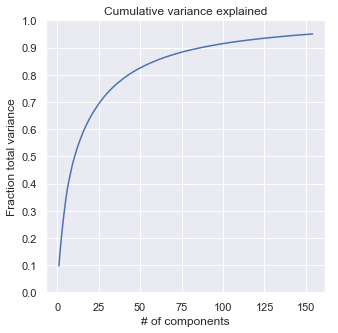

In [10]:
_ = ush.plot_cum_variance(pca_mnist)

variance_goal_pct = 95
features_for_goal = ush.num_components_for_cum_variance(pca_mnist, .01 * variance_goal_pct)
print("To capture {f:d}% of variance we need {d:d} synthetic features.".format(f=variance_goal_pct, d=features_for_goal))


So we need only about 20% of the original 784 features to capture 95% of the variance.

We can invert the PCA transformation to go from synthetic feature space back to original features.

That is, we can see what the digits look like when reconstructed from only 154 synthetic features.

First, let's look at the original:

(52500, 154)

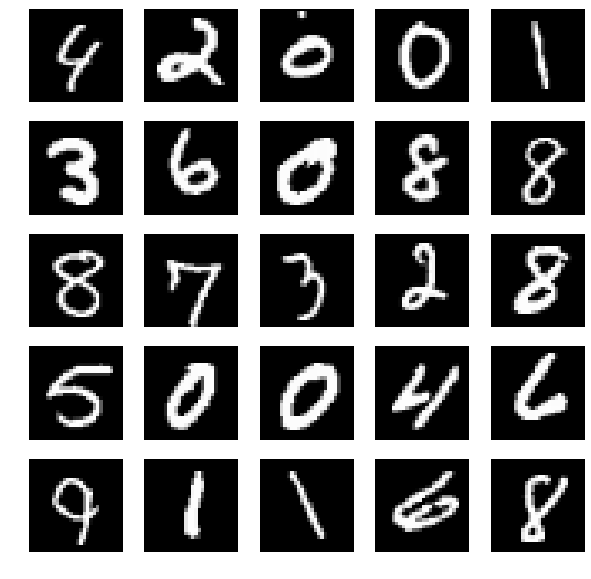

In [30]:

X_mnist_train_reduced = ush.transform(X_mnist_train, pca_mnist)
X_mnist_train_reduced.shape

# Show the original dataset
ush.mnh.visualize(X_mnist_train, y_mnist_train)

Next, the reconstructed

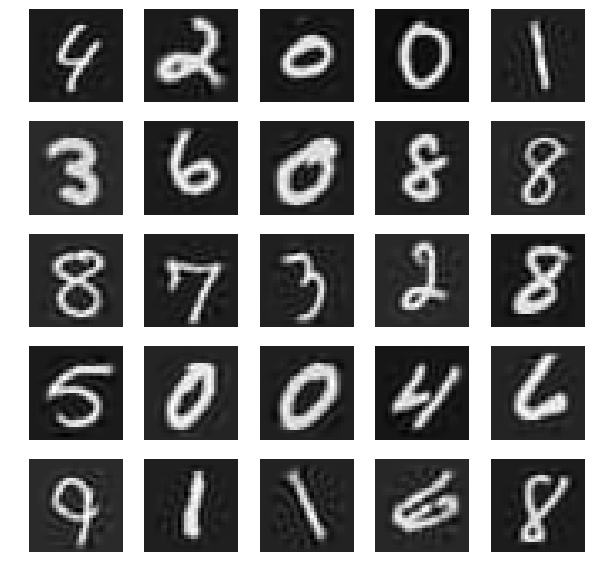

In [12]:
X_mnist_train_reconstruct = ush.inverse_transform(X_mnist_train_reduced, pca_mnist)
ush.mnh.visualize(X_mnist_train_reconstruct, y_mnist_train)

A little fuzzy, but pretty good.

Suppose we retained only 2 synthetic features.  We would be able to plot each sample in
two dimensions using the transformed coordinates.

Although targets are not necessary for PCA, here we do have labels associated with the images.

Let's plot the samples and color them according to their target.

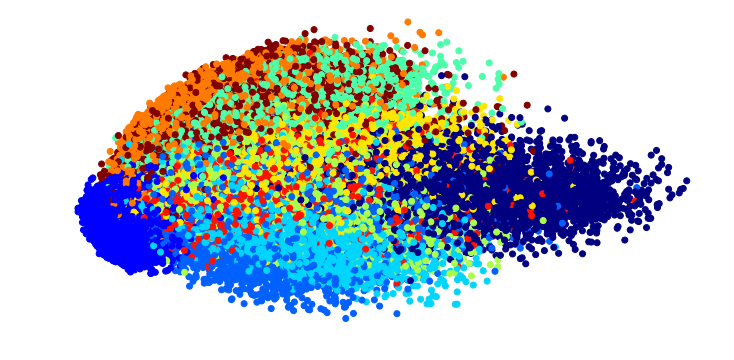

In [13]:
_ = ush.mnist_plot_2D(X_mnist_train_reduced, y_mnist_train.astype(int))

Each color is a different digit.

You can see that the clustering is far from perfect, but also suprisingly good considering we're using only 2 out of 784 features

Let's see how much variance is captured by only the first two synthetic features.

In [14]:
cumvar_mnist = np.cumsum(pca_mnist.explained_variance_ratio_)
first_comp =2
cumvar_first = cumvar_mnist[first_comp-1]

print("Cumulative variance of {d:d} PC's is {p:.2f}%, about {n:.1f} pixels".format(
    d=first_comp, p=100 *cumvar_first, n=cumvar_first * X_mnist_train.shape[1]))


Cumulative variance of 2 PC's is 16.89%, about 132.4 pixels


Is 17% good ?  You bet !

With 784 original features (pixels), if each features had equal importance, it would explain $1/784 = .12\%$ of the variance.  

So the first synthetic feature captures the variance of 132 original features (assuming all were of equal importance).


## A word on the inverse transformation

The transformation into synthetic features is
$$
T = X V
$$

If we multiply $T$ by $V^T$
$$
    T V^T = X V V^T = X
$$

So 
- $V$ transforms from original features to synthetic feature
- $V^T$ is the inverse transformation from synthetic features to original features


## Digits example

`sklearn` comes with a "digits" dataset that is like a low resolution version of MNIST: 8 by 8 pixels.

VanderPlas has a good [notebook](external/PythonDataScienceHandbook/notebooks/05.09-Principal-Component-Analysis.ipynb#PCA-as-dimensionality-reduction) illustrating PCA on this much smaller dataset.

We'll give a quick take on this, but I recommend the notebook.

Let's look at the digits data

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

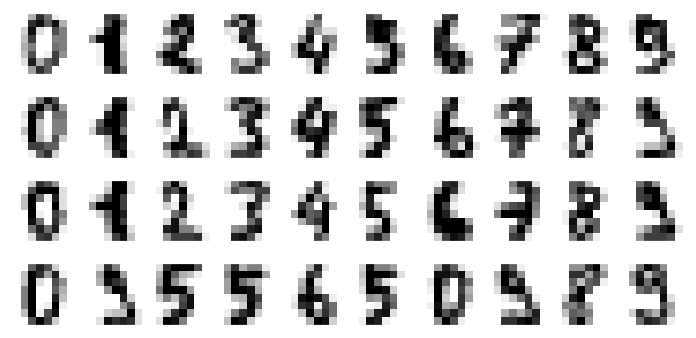

In [16]:
_ = vp.digits_plot(digits.data)

As you can see, each digit is represented by a grid of $8 \times 8$ pixels.

Let's reduce digits from 64 dimensions to only 2 and use this for clustering.

We project to 2 dimensions and then use an inverse transformation to reconstruct back to original feature space.

First, recall that if we retained all 64 sythetic features, we'd get a perfect reconstruction:

(1797, 64)
(1797, 64)


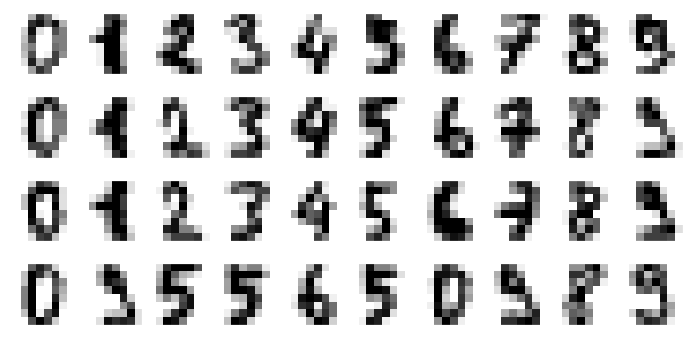

In [17]:
digits_pca, digits_projected, digits_reconstructed = vp.digits_reconstruction(digits.data)


Here's the reconstruction when retaining only 2 synthetic features.

(1797, 64)
(1797, 2)


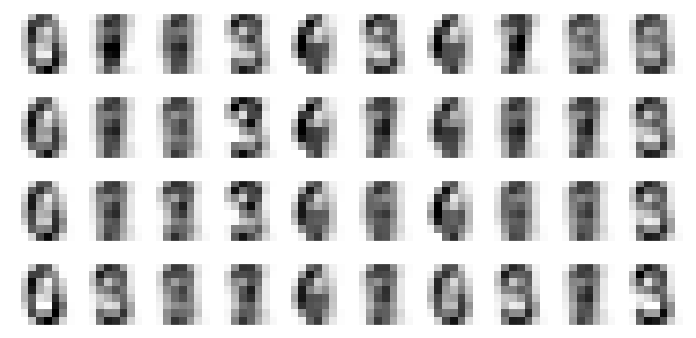

In [18]:
digits_pca2, digits_projected2, digits_reconstructed2 = vp.digits_reconstruction(digits.data, n_components=2)

Reconstruction is kind of fuzzy but the digits are recognizable. 

How much variance did we retain ?


In [19]:
cumvar_digits = np.cumsum(digits_pca2.explained_variance_ratio_)
first_comp =2
cumvar_first = cumvar_digits[first_comp-1]

print("Cumulative variance of {d:d} PC's is {p:.2f}%, about {n:.1f} pixels".format(
    d=first_comp, p=100 *cumvar_first, n=cumvar_first * digits.data.shape[1]))


Cumulative variance of 2 PC's is 28.51%, about 18.2 pixels


Two synthetic features capture almost 30% of the total variance.

More imporantly, let's visualize the clusters in synthetic feature (PC) space.

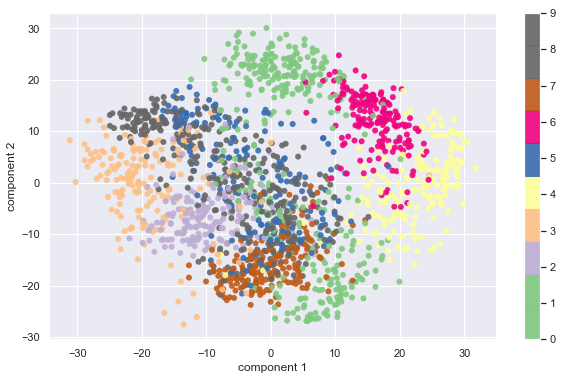

In [20]:
vp.digits_show_clustering(digits_projected2, digits.target)

Sometimes you an interpret the PC's by looking how they separate the clusters.

I admit: don't see it here though.

What would happen if we retained more than 2 synthetic features ?

Cumulative variance of 2 PCs is 0.285


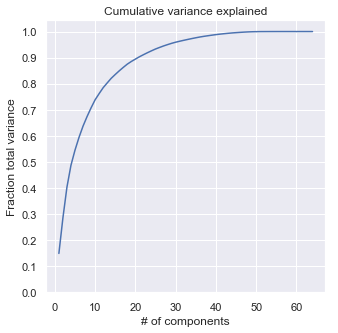

In [21]:
_ = vp.plot_cum_variance(digits_pca)
cumsum = np.cumsum(digits_pca.explained_variance_ratio_)
print("Cumulative variance of {nc:d} PCs is {cv:0.3f}".format(nc=2, cv=cumsum[2-1]) )

# PCA in Finance

## PCA of yield curve

[Litterman Scheinkman](https://www.math.nyu.edu/faculty/avellane/Litterman1991.pdf)

This is one of the most important papers (my opinion) in quantitative Fixed Income.

It allows us to hedge a large portfolio of bonds with a handful of instruments.


Let's get the history of Yield Curves and look at first few samples.

In [22]:
ych = ushelp.YieldCurve_PCA()

# Get the yield curve data
data_yc = ych.create_data()
data_yc.head()

,1M,2M,3M,6M,1J,2J,3J,4J,5J,6J,7J,8J,9J,10J
1992-02-29,0.0961,0.09610,0.0961,0.0958,0.0898,0.0864,0.0849,0.0837,0.0826,0.0817,0.0810,0.0806,0.0803,0.0804
1992-03-31,0.0970,0.09700,0.0970,0.0969,0.0912,0.0889,0.0877,0.0864,0.0852,0.0841,0.0833,0.0827,0.0823,0.0823
1992-04-30,0.0975,0.09750,0.0975,0.0975,0.0920,0.0892,0.0877,0.0862,0.0848,0.0837,0.0828,0.0822,0.0817,0.0816
1992-05-31,0.0978,0.09785,0.0979,0.0979,0.0920,0.0889,0.0874,0.0860,0.0847,0.0836,0.0828,0.0821,0.0817,0.0815
1992-06-30,0.0974,0.09745,0.0975,0.0975,0.0931,0.0904,0.0889,0.0874,0.0860,0.0848,0.0839,0.0832,0.0827,0.0825


In [23]:
data_yc.shape

(287, 14)

Each sample (row) are the yields for 14 maturity points on a given date.

Let's plot the history of yield curves

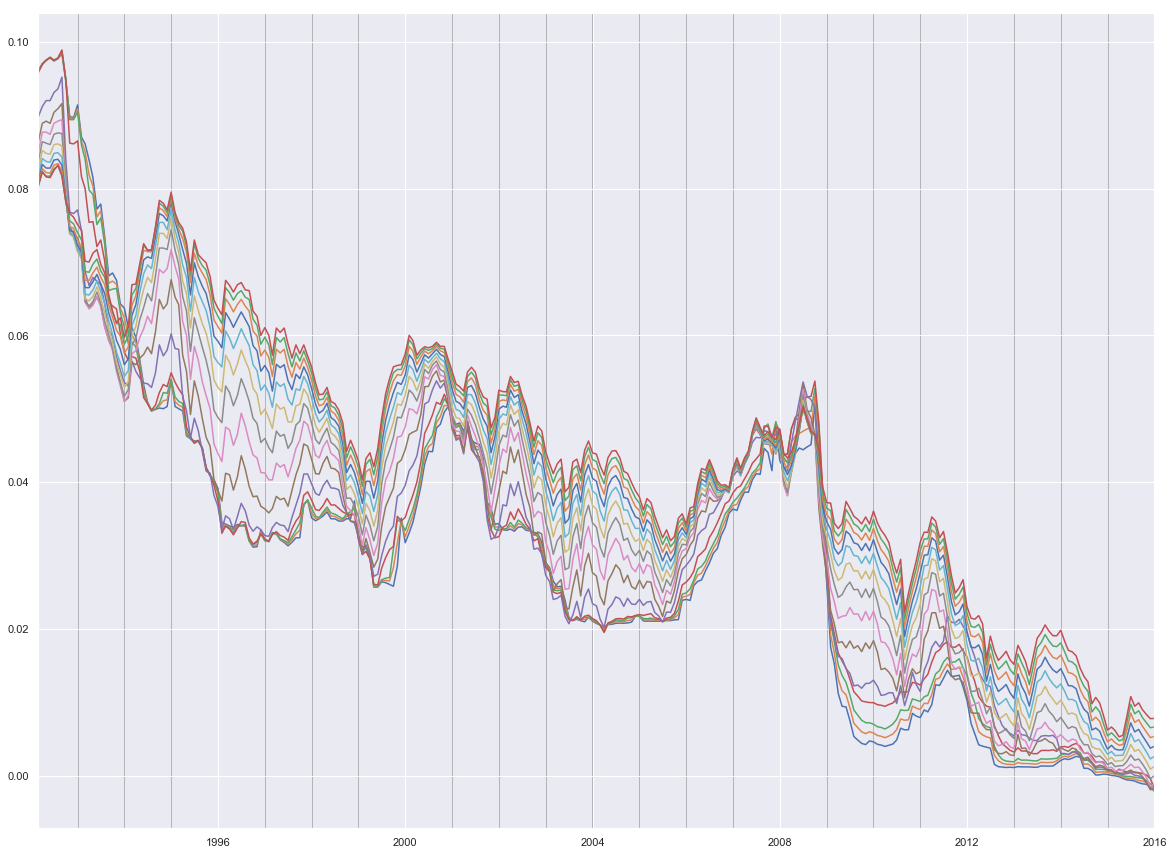

In [24]:
ych.plot_YC(data_yc)

Let's perform PCA on the **changes** in Yield Curve.

- features: yield changes on each of 14 times to maturity
- samples: Yield Curve (changes) observed on each day

By explaining changes with a small number of synthetic features, we will be able to hedge a large portfolio
of bonds with a small number of instruments:
- find the synthetic features
- for our portfolio: find the exposure to the synthetic features (sum over bonds in portfolio)
- create a hedge portfolio, with few instruments, that has the same exposure to the synthetic features
- short the hedge portfolio: the net portfolio should be relatively immune to changes in the Yield Curve.

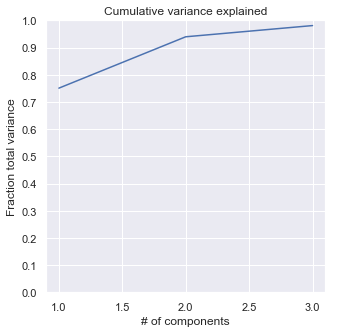

In [31]:
pca_yc, df_pca_yc = ych.doPCA(data_yc, doDiff=True)
_ = ych.plot_cum_variance(pca_yc)

Wow ! Only 3 synthetic features capture almost all the variance of the original 14 !

Can we interpret what these synthetic features are ?

Let's examine the effect of a 1 standard deviation move in each synthetic feature on
original features.  

We arrange the original features by maturity on the horizontal axis
and plot the effect on the vertical.

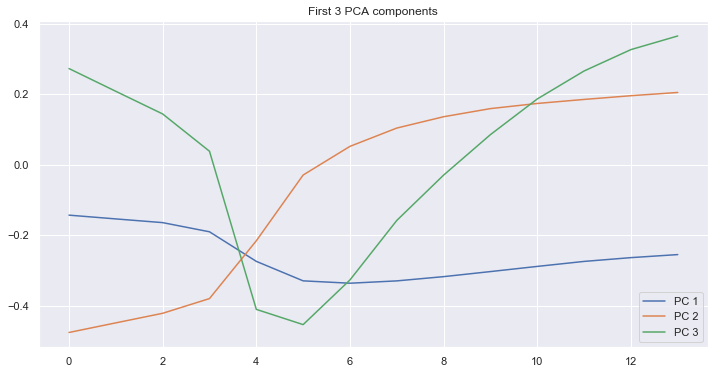

In [26]:
ych.plot_components(pca_yc)

This is a very typical pattern in Finance:
- the first synthetic feature affects all maturities equally
    - parallel shift in yield curve
- the second synthetic feature shows a dichotomy (one original feature against another)
    - longer maturities affected more than short
    - slope shift in yield curve
- the third synthetic feature is the difference between the middle and the two ends
    - a "twist" in the yield curve around the 5 year maturity

**Recall**

The synthetic features are standardized, hence 1 unit is one standard deviation.
The $\Sigma$ matrix re-scales from standard deviation to original feature space.

So can't compare the levels on the vertical axis between synthetic features.

Since $\sigma_1 > \sigma_2$ the absolute effect on a maturity of synthetic feature 1 is greater than the
effect of synthetic feature 2 for a 1 standard deviation move in each.

## PCA of the SP 500

Don't have time to do it here, but the first components tend to be:
- index change (equal weight on all features, i.e., stocks)
- dichotomy
    - not always obvious (or constant over time) what is being contrasted
        - cyclical vs non-cyclical
        - industry vs industry
        - small vs big cap
    - Note: the samples don't always come with the "theory" (e.g., industry) attached; you have to do it.

# Clustering

Arrange samples into groups, based on similarity of features.

We will briefly review some methods.


## PCA: an enabler for clustering

When we plot samples in the new, synthetic feature space, clusters often become apparant to the human eye.

This however is not clustering: we need an algorithm to achieve what the human intuits.

Principal Component decomposition is complementary to Clustering but, by using PCA to reduce dimensions,
it is often easier (and faster) to find clusters.


## K-means clustering
## Hierarchical clustering

# Recommender Systems: Approximate SVD

There is another interesting use of Matrix Factorization that we will briefly review.

It will show both a case study and interesting extension of SVD.

## Netflix Prize competition
- Predict user ratings for movies
- Dataset
    - Ratings assigned by users to movies: 1 to 5 stars
    - 480K users, 18K movies; 100MM ratings total
- $1MM prize award to team that beat Netflix existing prediction system by at least 10 percent points

## User preference matrix

We will try to use same language as PCA (samples, features, synthetic features) but map them to Netflix terms
- Samples: Viewers
- Features: Movies ("items")

Matrix $X$: user rating of movies

$X_j^{(i)}$ is $i^{\text{th}}$ user's rating of movie $j$

$X$ is huge: $n *m$ where $n = .5$ million viewers and $m = 18,000$ items (movies).

About 9 billion entries for a full matrix !


## Idea: Linking Viewer to Movies via concepts

- Come up with your own "concepts" that relate user taste to movies
    - supply and demand: user demands concept, movie provides concept
- Create user profile $P$: maps user to concept
- Create item profile $Q$: maps movies (features, items) to concept
- $X = P Q^T$

### Human defined concepts
- style: action, adventure, comedy, sci-fi
- actor
- typical audience segment

One advantage of the $X = P Q^T$ approach is a big space reduction.

With $k \le m$ concepts:
- $X$ is $n \times m$
- $P$ is $n \times k$
- $Q$ is $m \times k$

So idea is to factor $X$ and discover $k \le m$ synthetic features (concepts, "latent factors)


- $X = P Q^T$
- Given a new user (test sample), predict rating for an unseen movie:
    - Get a partial vector of user's ratings (defined for movies seen by user) -- original feature space
    - Project onto concepts (synthetic feature space): use `transform` after initial fit to training)
    - Inverse transform to get back complete vector in original feature space



### SVD to discover concept

Why let a human guess what ML can discover ?  Use SVD to discover the $k$ "best" synthetic features, rather than leaving it to a person.

Factor $X$ by SVD !

$X = U \Sigma * V^T$

Let $P = U \Sigma, Q = V$

Anyone spot the problem(s) ?

- First: a matrix with 9 billion entries is a handful !

- As you can imagine, any single user views only a fraction of the $m$ movies
    - $X$ is very sparse 
    - Of the $9$ billion potential entries in the full matrix $X$, we only have $100$ million defined.

How can we perform SVD on matrix with missing values ?

- Missing value imputation
    - not attractive: most values are missing
- Pseudo SVD

**The ML mantra**
- find a (cool ?) cost function that describes a solution to your problem
- Use Gradient Descent to solve

## Pseudo SVD Cost function

The Froebenius Norm (used above) modified to exclude missing values

$$
Cost(X', X) = \sum\limits_{\substack{1 \le i \le n,\\ 1 \le j \le m \\ X_j^{(i)} \text{defined}}} { \left(  X_j^{(i)} - {X'}_j^{(i)} \right)^2}
$$

where $X' = P Q^T$

Interpret as Reconstruction Error

### Pseudo SVD algorithm

- Define $X' = P Q^T$

- Take analytic derivatives of $Cost(X', X)$ with respect to
    - $P_j^{(i)}$ for $1 \le i \le n, 1 \le j \le k$
    - $Q_j^{(i)}$ for $1 \le i \le m, 1 \le j \le k$

- Initialize elements of $P, Q$ randomly.

- Use Gradient Descent to solve for optimal entries of $P, Q$.
    - find entries of $P, Q$ such that product matches non-empty part of $X$

**Note**
- No guarantee that the $P, Q$ obtained are
    - orthonormal, etc. (which SVD would give you)

But SVD won't work for $X$ with missing values.

### Filling in missing values

Once you have $P, Q$

- to predict a missing rating for user $i$ movie $j$:

$$\hat{r}_{x,i} =  q_i \cdot p_x^T$$ 
- $q_i$ is row $i$ of $Q$
- $p_x$ is column $x$ of $P^T$

### Some intuition

The rating vector of a user may have missing entries.

But we can still project to synthetic feature space based on the non-empty entries.

The projection winds up in a "neighborhood" of concepts.

Inverse transformation gets us to a completely non-empty rating vector that is a resident of this neighborhood.

**Example**

User rates Sci-Fi movies A and B very highly, but not C.

Since A,B, C express same concept (Sci-Fi) they will be close in synthetic feature space.

Hence, the implied rating of User for movie C will be close to what other users rate C.

In [27]:
print("Done")

Done
